# Creating bar plots to compare data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import matplotlib as mpl
import momlevel as ml
import gcsfs
import zarr
from matplotlib.ticker import FormatStrFormatter

In [2]:
mask_CM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/CM4_mask_antarctica.nc')
mask_ESM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ESM4_mask_antarctica.nc')

In [3]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
df_uas = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_uas	
# step two … # replace with the id you need and other info to ween down datasets 
df_u = df_uas.query("source_id=='GFDL-CM4' & experiment_id == 'piControl' & variable_id == 'uas'& table_id == 'Amon'")
df_u
# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_u.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_uas = xr.open_zarr(mapper, consolidated=True)

In [4]:
##importing Northward Near-Surface Wind data from google cloud.
df_vas = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_vas	
# step two … # replace with the id you need and other info to ween down datasets 
df_v = df_vas.query("source_id=='GFDL-CM4' & experiment_id == 'piControl' & variable_id == 'vas'& table_id == 'Amon'")
df_v
# step three 
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_v.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_vas = xr.open_zarr(mapper, consolidated=True)

In [5]:
## renaming the variables for the merge to get the wind speed.
Uas = ds_uas.uas
Vas = ds_vas.vas
Uas

<xarray.DataArray 'uas' (time: 6000, lat: 180, lon: 288)>
dask.array<open_dataset-uas, shape=(6000, 180, 288), dtype=float32, chunksize=(610, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [6]:
## selecting the UAS variable and renaming it to Uas_winds.
## This allows us to look at the value we want for eastward wind.
Uas_winds = ds_uas.uas
## Slicing the eastward wind into the south pole region, as well as averaging the 500 year time values.
## This provides the average for 500 year. Can be named whatever I just named it this bc im cool.
Uas_151_650 = Uas_winds.sel(lat=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
Uas_151_650

<xarray.DataArray 'uas' (lat: 35, lon: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [7]:
##UAS wind dataset defined above
Uas_winds
## slicing the UAS into south polar lat
Antsliceuas = Uas_winds.sel(lat=slice(-89.5,-55))
Antsliceuas
## grouping the data into seasons and averaging the 500 seasons
uas_seasonal = Antsliceuas.groupby('time.season').mean(dim='time')
uas_seasonal
## creating seasonal variables
uas_summer = uas_seasonal.sel(season='DJF') ##southern hemisphere has summer in december,jan,feb
uas_winter = uas_seasonal.sel(season='JJA') ### winter months in southern hemisphere
uas_spring = uas_seasonal.sel(season='SON') ## spring months in southern hemisphere
uas_fall = uas_seasonal.sel(season='MAM') ## fall months in southern hemisphere

In [8]:
## selecting the Vas variable and naming it to Vas_winds. allows us to look at northward winds.
Vas_winds = ds_vas.vas
## slicing Vas_winds to south polar region and averaging 500 year to get average.
Vas_151_650 = Vas_winds.sel(lat=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
Vas_151_650

<xarray.DataArray 'vas' (lat: 35, lon: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [9]:
## VAS data set as defined earlier
Vas_winds
## slicing vas into south pole lat
antslicevas = Vas_winds.sel(lat=slice(-89.5,-55))
## grouping Vas into seasons and averaging the 500 seasons.
vas_seasonal = antslicevas.groupby('time.season').mean(dim='time')
## plotting to see DJF / month values
vas_seasonal
## creating seasonal variables ## im not sure we need these actually...
vas_summer = vas_seasonal.sel(season='DJF') ##southern hemisphere has summer in december,jan,feb
vas_winter = vas_seasonal.sel(season='JJA') ### winter months in southern hemisphere
vas_spring = vas_seasonal.sel(season='SON') ## spring months in southern hemisphere
vas_fall = vas_seasonal.sel(season='MAM') ## fall months in southern hemisphere

In [10]:
## merge winds by merging eastward and northward.
mergewinds = xr.merge([Uas,Vas]) # merge winds to make it easy
xmerge = mergewinds.lon #extracting the lon component fomr the mergewinds array
ymerge = mergewinds.lat
umerge = mergewinds.uas 
vmerge = mergewinds.vas
speedmerge = np.sqrt(np.square(umerge) + np.square(vmerge)) ## calculating speed using vector sum formula
## average
timeaveragemerge = mergewinds.sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
timeaveragemerge

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 288)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Data variables:
    uas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
    vas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>

In [11]:
### slicing the speed for the south pole
speedslice = speedmerge.sel(lat=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')

In [12]:
## UAS seasonal dataset
uas_seasonal
## VAS seasonal plot
vas_seasonal
## merging the UAS seasonal and Vas seasonal to get merge seasonal
seasonalmerge = xr.merge([uas_seasonal,vas_seasonal])
seasonalmerge

<xarray.Dataset>
Dimensions:  (lat: 35, lon: 288, season: 4)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    uas      (season, lat, lon) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
    vas      (season, lat, lon) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [13]:
## calculating the seasonal wind speed
seasonalspeedmerge = np.sqrt(np.square(seasonalmerge.uas) + np.square(seasonalmerge.vas))
## slicing the summer speed
Summer_szn_speed = seasonalspeedmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
Summer_szn= seasonalmerge.sel(season='DJF')
## slicing seasonalspeed to get speed for winter and averaging it
Winter_szn_speed = seasonalspeedmerge.sel(season=slice('JJA')).mean(dim='season')
Winter_szn= seasonalmerge.sel(season='JJA')
## FALL seasonal speed merge and averaging
Fall_szn_speed = seasonalspeedmerge.sel(season=slice('MAM')).mean(dim='season')
Fall_szn= seasonalmerge.sel(season='MAM')
## slicing seasonalspeed to get spring values and averaging it
Spring_szn_speed = seasonalspeedmerge.sel(season=slice('SON')).mean(dim='season')
Spring_szn= seasonalmerge.sel(season='SON')

# ESM4

In [14]:
google_cloud_cmip6 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [15]:
#defines the Eastward Near-Surface Wind
gfdl_esm4_uas_data = google_cloud_cmip6.query(
    "table_id == 'Amon' & \
    variable_id == 'uas' & \
    experiment_id == 'piControl' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_uas = gfdl_esm4_uas_data.zstore.values[-1]
mapper_esm4_uas = gcs.get_mapper(zstore_esm4_uas)

esm4_uas = xr.open_zarr(mapper_esm4_uas, 
                                consolidated=True,use_cftime=True).uas.rename({'lat':'latitude',
                                                             'lon':'longitude'})

#defines the NorthWard Near-Surface Wind
gfdl_esm4_vas_data = google_cloud_cmip6.query(
    "table_id == 'Amon' & \
    variable_id == 'vas' & \
    experiment_id == 'piControl' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

zstore_esm4_vas = gfdl_esm4_vas_data.zstore.values[-1]
mapper_esm4_vas = gcs.get_mapper(zstore_esm4_vas)

esm4_vas = xr.open_zarr(mapper_esm4_vas, 
                                consolidated=True,use_cftime=True).vas.rename({'lat':'latitude',
                                                             'lon':'longitude'})

In [16]:
uase4=esm4_uas#.sel(time=slice('0001-01-16','0500-01-16')).mean(dim='time')#.groupby('time.season').mean(dim='time')
vase4 = esm4_vas#.sel(time=slice('0001-01-16','0500-01-16')).mean(dim='time')

In [17]:
uase4

<xarray.DataArray 'uas' (time: 6000, latitude: 180, longitude: 288)>
dask.array<open_dataset-uas, shape=(6000, 180, 288), dtype=float32, chunksize=(611, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height     float64 ...
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * time       (time) object 0001-01-16 12:00:00 ... 0500-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [18]:
## Slicing the eastward wind into the south pole region, as well as averaging the 500 year time values.
## This provides the average for 500 year. Can be named whatever I just named it this bc im cool.
uase4_500_avg=uase4.sel(latitude=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')

In [19]:
uase4 #eastward wind variable
## slicing the uase4 into south polar lat
ESM4_Antsliceuas = uase4.sel(latitude=slice(-89.5,-55))
ESM4_Antsliceuas
## grouping the data into seasons and averaging the 500 seasons
ESM4_uas_seasonal = ESM4_Antsliceuas.groupby('time.season').mean(dim='time')
ESM4_uas_seasonal
## grouping into seasonal varibles 
ESM4_uas_summer = ESM4_uas_seasonal.sel(season='DJF') ##southern hemisphere has summer in december,jan,feb
ESM4_uas_winter = ESM4_uas_seasonal.sel(season='JJA') ### winter months in southern hemisphere
ESM4_uas_spring = ESM4_uas_seasonal.sel(season='SON') ## spring months in southern hemisphere
ESM4_uas_fall = ESM4_uas_seasonal.sel(season='MAM') ## fall months in southern hemisphere

In [20]:
## Slicing the eastward wind into the south pole region, as well as averaging the 500 year time values.
## This provides the average for 500 year. Can be named whatever I just named it this bc im cool.
vase4_500_avg=vase4.sel(latitude=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
vase4 #northward wind variable
## slicing the vase4 into south polar lat
ESM4_Antslicevas = vase4.sel(latitude=slice(-89.5,-55))
ESM4_Antslicevas
## grouping the data into seasons and averaging the 500 seasons
ESM4_vas_seasonal = ESM4_Antslicevas.groupby('time.season').mean(dim='time')
ESM4_vas_seasonal
## creating seasonal variables 
ESM4_vas_summer = ESM4_vas_seasonal.sel(season='DJF') ##southern hemisphere has summer in december,jan,feb
ESM4_vas_winter = ESM4_vas_seasonal.sel(season='JJA') ### winter months in southern hemisphere
ESM4_vas_spring = ESM4_vas_seasonal.sel(season='SON') ## spring months in southern hemisphere
ESM4_vas_fall = ESM4_vas_seasonal.sel(season='MAM') ## fall months in southern hemisphere

In [21]:
uase4=esm4_uas#.sel(time=slice('0001-01-16','0500-01-16')).mean(dim='time')#.groupby('time.season').mean(dim='time')
vase4 = esm4_vas#.sel(time=slice('0001-01-16','0500-01-16')).mean(dim='time')
mergedwindse4 = xr.merge([uase4,vase4])
esm4_xmerge=mergedwindse4.longitude
esm4_ymerge=mergedwindse4.latitude
esm4_umerge=mergedwindse4.uas
esm4_vmerge=mergedwindse4.vas
esm4_speed_merge=np.sqrt(np.square(esm4_umerge) + np.square(esm4_vmerge)).sel(latitude=slice(-90,-55))
esm4_speed_merge
#wind speed around antarctica 
#####
esm4_timeaveragemerge = mergedwindse4.sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
esm4_timeaveragemerge

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 288)
Coordinates:
    height     float64 10.0
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
Data variables:
    uas        (latitude, longitude) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
    vas        (latitude, longitude) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>

In [22]:
### slicing the speed for the south pole
ESM4_speedslice = esm4_speed_merge.sel(latitude=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
ESM4_speedslice
##
ESM4_uas_seasonal #defined earlier
ESM4_vas_seasonal #defined earlier
## merging the UAS seasonal and Vas seasonal to get merge seasonal
esm4_seasonalmerge = xr.merge([ESM4_uas_seasonal,ESM4_vas_seasonal])
esm4_seasonalmerge
##
## calculating the seasonal wind speed
esm4_SPEED_seasonalmerge = np.sqrt(np.square(esm4_seasonalmerge.uas) + np.square(esm4_seasonalmerge.vas))
esm4_SPEED_seasonalmerge
## merging the UAS seasonal and Vas seasonal to get merge seasonal
esm4_seasonalmerge = xr.merge([ESM4_uas_seasonal,ESM4_vas_seasonal])
esm4_seasonalmerge
#this has the same variables

<xarray.Dataset>
Dimensions:    (latitude: 35, longitude: 288, season: 4)
Coordinates:
    height     float64 10.0
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... -57.5 -56.5 -55.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    uas        (season, latitude, longitude) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
    vas        (season, latitude, longitude) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [23]:
esm4_SPEED_seasonalmerge = np.sqrt(np.square(esm4_seasonalmerge.uas) + np.square(esm4_seasonalmerge.vas))
esm4_SPEED_seasonalmerge
## slicing the summer speed
ESM4_Summer_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
ESM4_Summer_szn= esm4_seasonalmerge.sel(season='DJF') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL
## slicing the winter speed
ESM4_winter_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('JJA')).mean(dim='season')
## Slicing winter season from seasonalmerge
ESM4_winter_szn= esm4_seasonalmerge.sel(season='JJA') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL
## slicing the fall speed
ESM4_fall_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('MAM')).mean(dim='season')
## Slicing fall season from seasonalmerge
ESM4_fall_szn= esm4_seasonalmerge.sel(season='MAM') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL
## slicing the spring speed
ESM4_spring_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('SON')).mean(dim='season')
## Slicing spring season from seasonalmerge
ESM4_spring_szn= esm4_seasonalmerge.sel(season='SON') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

# Start Bar Plots

In [24]:
#rename coordinates to make things easy and consistent
esm4_speedslice_rename=ESM4_speedslice.rename({'latitude': 'lat', 'longitude': 'lon'}) 
esm4_speedslice_rename

<xarray.DataArray (lat: 35, lon: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [25]:
#time is already averaged out from speed slice
#here we are averaging the wind speed of each region into one value to compare on a bar plot
#this is annual windspeed averaged over 500 years
plateau_temp_total_ESM4=(esm4_speedslice_rename*(mask_ESM4.plateau_ESM4)).mean(dim='lat').mean(dim='lon')
ross_temp_total_ESM4=(esm4_speedslice_rename*(mask_ESM4.ross_ESM4)).mean(dim='lat').mean(dim='lon')
lowwest_temp_total_ESM4=(esm4_speedslice_rename*(mask_ESM4.lowwest_ESM4)).mean(dim='lat').mean(dim='lon')
loweast_temp_total_ESM4=(esm4_speedslice_rename*(mask_ESM4.loweast_ESM4)).mean(dim='lat').mean(dim='lon')
filchner_temp_total_ESM4=(esm4_speedslice_rename*(mask_ESM4.filchner_ESM4)).mean(dim='lat').mean(dim='lon')
peninsula_temp_total_ESM4=(esm4_speedslice_rename*(mask_ESM4.peninsula_ESM4)).mean(dim='lat').mean(dim='lon')

In [26]:
plat_value_ESM4_total=print(plateau_temp_total_ESM4.values)
ross_value_ESM4_total= print(ross_temp_total_ESM4.values)
west_value_ESM4_total=print(lowwest_temp_total_ESM4.values)
east_value_ESM4_total=print(loweast_temp_total_ESM4.values)
filch_value_ESM4_total=print(filchner_temp_total_ESM4.values)
pen_value_ESM4_total=print(peninsula_temp_total_ESM4.values)

4.6110106
3.0387483
5.54752
6.7986307
2.5159395
3.7758267


In [27]:
esm4_regional_annual_values=[4.6110106,
3.0387483,
5.54752,
6.7986307,
2.5159395,
3.7758267]
esm4_regional_annual_values

[4.6110106, 3.0387483, 5.54752, 6.7986307, 2.5159395, 3.7758267]

In [28]:
cm4_speedslice=speedslice

In [29]:
plateau_temp_total_CM4=(cm4_speedslice*(mask_CM4.plateau_CM4)).mean(dim='lat').mean(dim='lon')
ross_temp_total_CM4=(cm4_speedslice*(mask_CM4.ross_CM4)).mean(dim='lat').mean(dim='lon')
lowwest_temp_total_CM4=(cm4_speedslice*(mask_CM4.lowwest_CM4)).mean(dim='lat').mean(dim='lon')
loweast_temp_total_CM4=(cm4_speedslice*(mask_CM4.loweast_CM4)).mean(dim='lat').mean(dim='lon')
filchner_temp_total_CM4=(cm4_speedslice*(mask_CM4.filchner_CM4)).mean(dim='lat').mean(dim='lon')
peninsula_temp_total_CM4=(cm4_speedslice*(mask_CM4.peninsula_CM4)).mean(dim='lat').mean(dim='lon')

In [30]:
plat_value_CM4_total=print(plateau_temp_total_CM4.values)
ross_value_CM4_total= print(ross_temp_total_CM4.values)
west_value_CM4_total=print(lowwest_temp_total_CM4.values)
east_value_CM4_total=print(loweast_temp_total_CM4.values)
filch_value_CM4_total=print(filchner_temp_total_CM4.values)
pen_value_CM4_total=print(peninsula_temp_total_CM4.values)

4.577921
2.954114
5.407377
6.6425905
2.413058
3.6138852


In [31]:
cm4_regional_annual_values=[4.577921,
2.954114,
5.407377,
6.6425905,
2.413058,
3.6138852]
cm4_regional_annual_values

[4.577921, 2.954114, 5.407377, 6.6425905, 2.413058, 3.6138852]

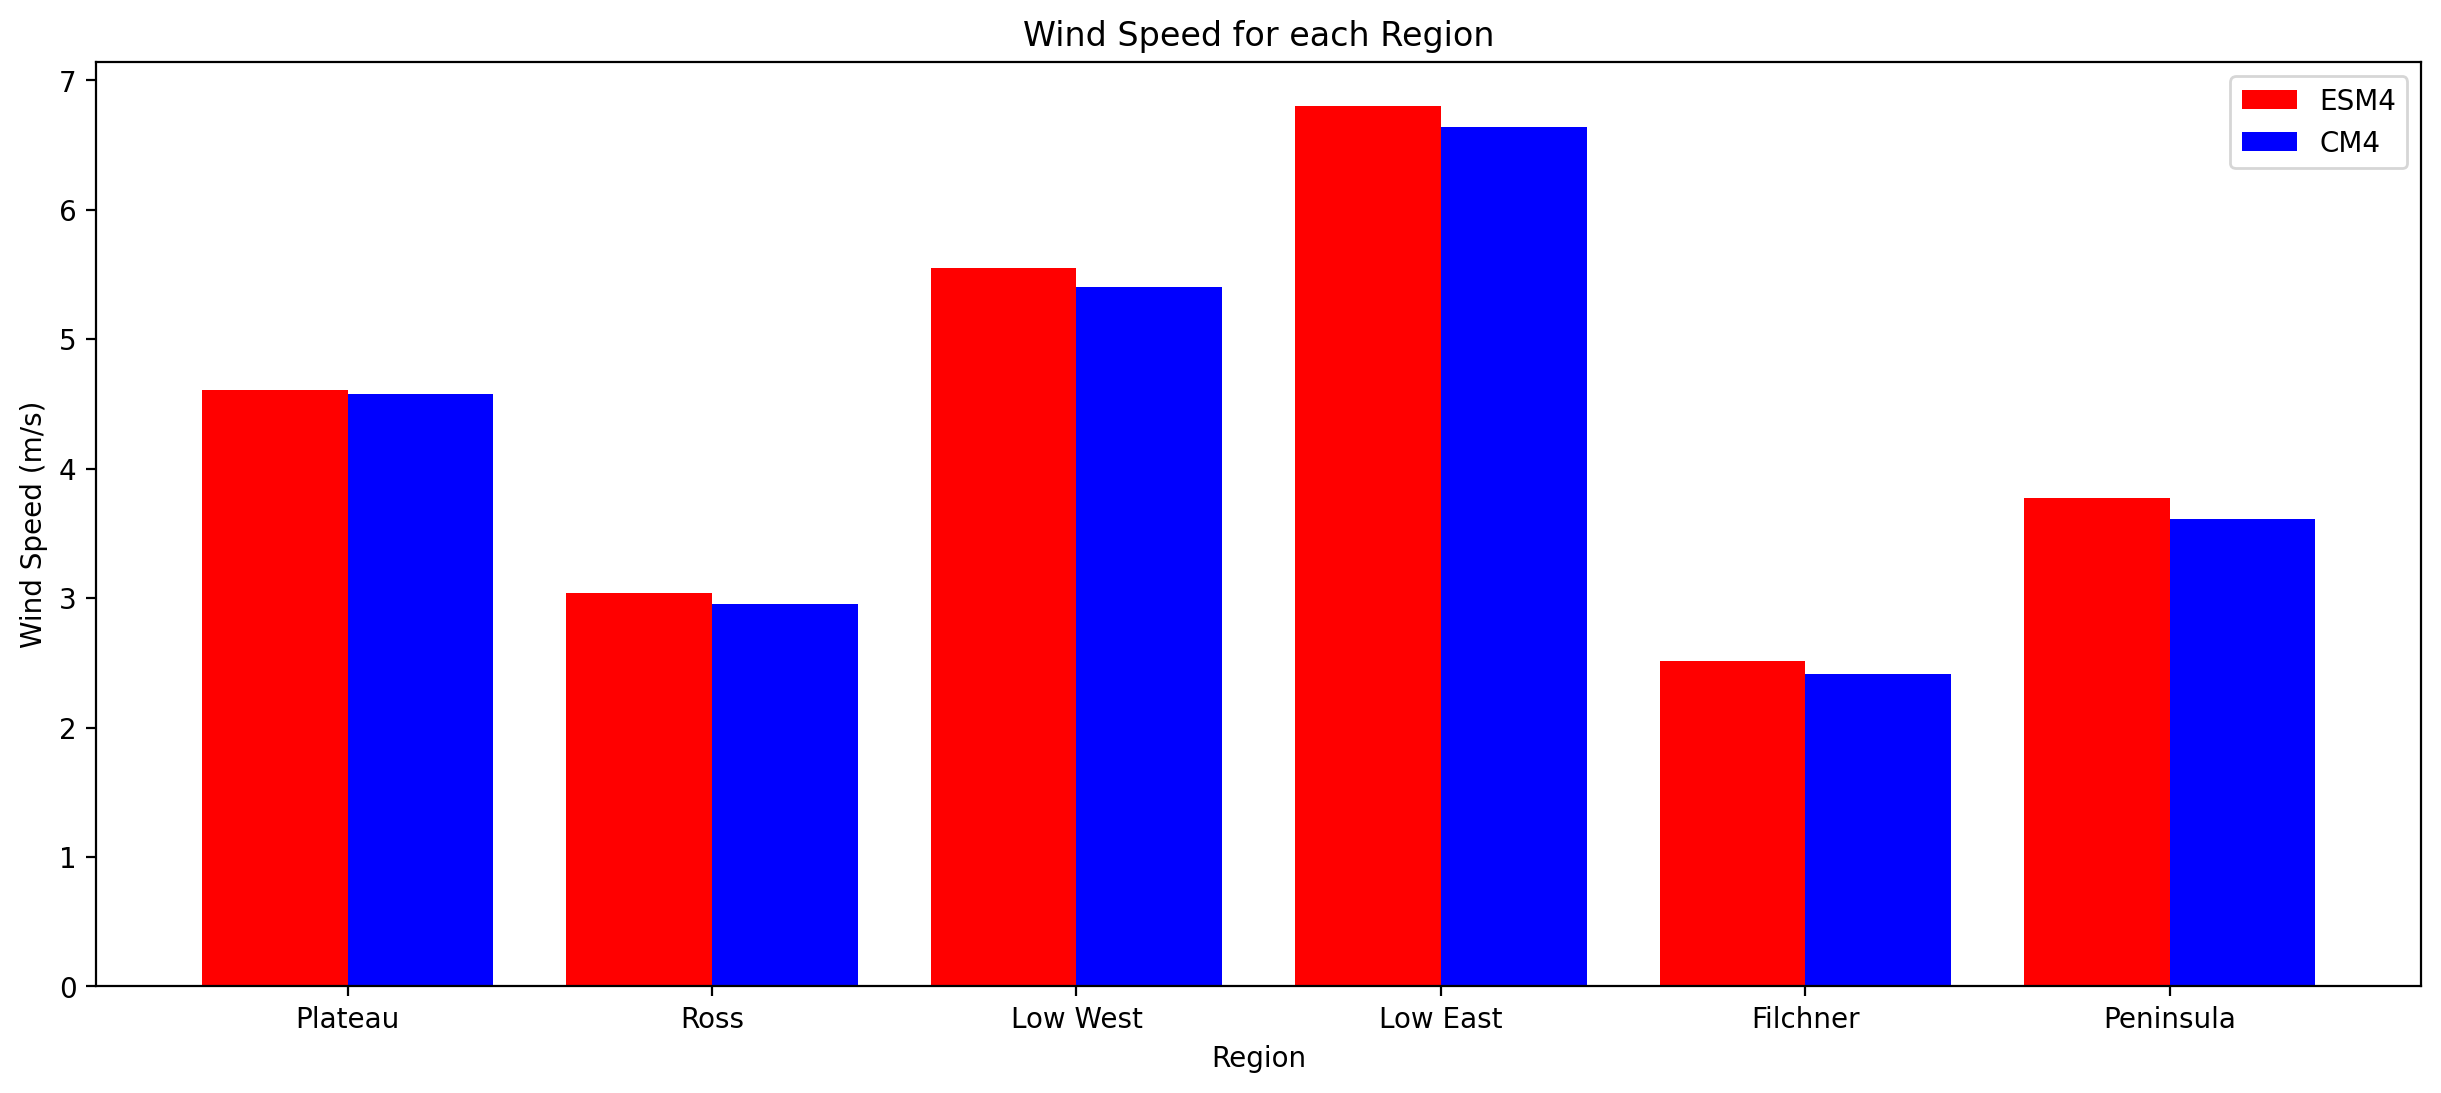

In [32]:
#bar plot showing differences in cm4 and esm4 data for regional annual windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = cm4_regional_annual_values
ESM4 = esm4_regional_annual_values
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, ESM4, 0.4, label = 'ESM4', color='r') 
plt.bar(X_axis + 0.2, CM4, 0.4, label = 'CM4', color= 'blue') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

# Summer DJF

In [33]:
ESM4_Summer_szn_speed_rename=ESM4_Summer_szn_speed.rename({'latitude': 'lat', 'longitude': 'lon'}) 

In [34]:
#time is already averaged out from speed slice
#here we are averaging the wind speed of each region into one value to compare on a bar plot
#this is annual windspeed averaged over 500 years
summer_plateau_temp_total_ESM4=(ESM4_Summer_szn_speed_rename*(mask_ESM4.plateau_ESM4)).mean(dim='lat').mean(dim='lon')
summer_ross_temp_total_ESM4=(ESM4_Summer_szn_speed_rename*(mask_ESM4.ross_ESM4)).mean(dim='lat').mean(dim='lon')
summer_lowwest_temp_total_ESM4=(ESM4_Summer_szn_speed_rename*(mask_ESM4.lowwest_ESM4)).mean(dim='lat').mean(dim='lon')
summer_loweast_temp_total_ESM4=(ESM4_Summer_szn_speed_rename*(mask_ESM4.loweast_ESM4)).mean(dim='lat').mean(dim='lon')
summer_filchner_temp_total_ESM4=(ESM4_Summer_szn_speed_rename*(mask_ESM4.filchner_ESM4)).mean(dim='lat').mean(dim='lon')
summer_peninsula_temp_total_ESM4=(ESM4_Summer_szn_speed_rename*(mask_ESM4.peninsula_ESM4)).mean(dim='lat').mean(dim='lon')

In [35]:
summer_plat_value_ESM4_total=print(summer_plateau_temp_total_ESM4.values)
summer_ross_value_ESM4_total= print(summer_ross_temp_total_ESM4.values)
summer_west_value_ESM4_total=print(summer_lowwest_temp_total_ESM4.values)
summer_east_value_ESM4_total=print(summer_loweast_temp_total_ESM4.values)
summer_filch_value_ESM4_total=print(summer_filchner_temp_total_ESM4.values)
summer_pen_value_ESM4_total=print(summer_peninsula_temp_total_ESM4.values)

3.2847826
2.1121225
3.7046726
4.6893525
1.5164547
2.3290417


In [36]:
summer_esm4_values=[3.2847826,
2.1121225,
3.7046726,
4.6893525,
1.5164547,
2.3290417]

# CM4 Summer

In [37]:
Summer_szn_speed

<xarray.DataArray (lat: 35, lon: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [38]:
summer_plateau_temp_total_CM4=(Summer_szn_speed*(mask_CM4.plateau_CM4)).mean(dim='lat').mean(dim='lon')
summer_ross_temp_total_CM4=(Summer_szn_speed*(mask_CM4.ross_CM4)).mean(dim='lat').mean(dim='lon')
summer_lowwest_temp_total_CM4=(Summer_szn_speed*(mask_CM4.lowwest_CM4)).mean(dim='lat').mean(dim='lon')
summer_loweast_temp_total_CM4=(Summer_szn_speed*(mask_CM4.loweast_CM4)).mean(dim='lat').mean(dim='lon')
summer_filchner_temp_total_CM4=(Summer_szn_speed*(mask_CM4.filchner_CM4)).mean(dim='lat').mean(dim='lon')
summer_peninsula_temp_total_CM4=(Summer_szn_speed*(mask_CM4.peninsula_CM4)).mean(dim='lat').mean(dim='lon')

In [39]:
summer_plat_value_CM4_total=print(summer_plateau_temp_total_CM4.values)
summer_ross_value_CM4_total= print(summer_ross_temp_total_CM4.values)
summer_lowwest_value_CM4_total=print(summer_lowwest_temp_total_CM4.values)
summer_loweast_value_CM4_total=print(summer_loweast_temp_total_CM4.values)
summer_filch_value_CM4_total=print(summer_filchner_temp_total_CM4.values)
summer_pen_value_CM4_total=print(summer_peninsula_temp_total_CM4.values)

3.039674
1.8924025
3.2528682
4.2702117
1.300003
1.936459


In [40]:
summer_cm4_values=[3.039674,
1.8924025,
3.2528682,
4.2702117,
1.300003,
1.936459]


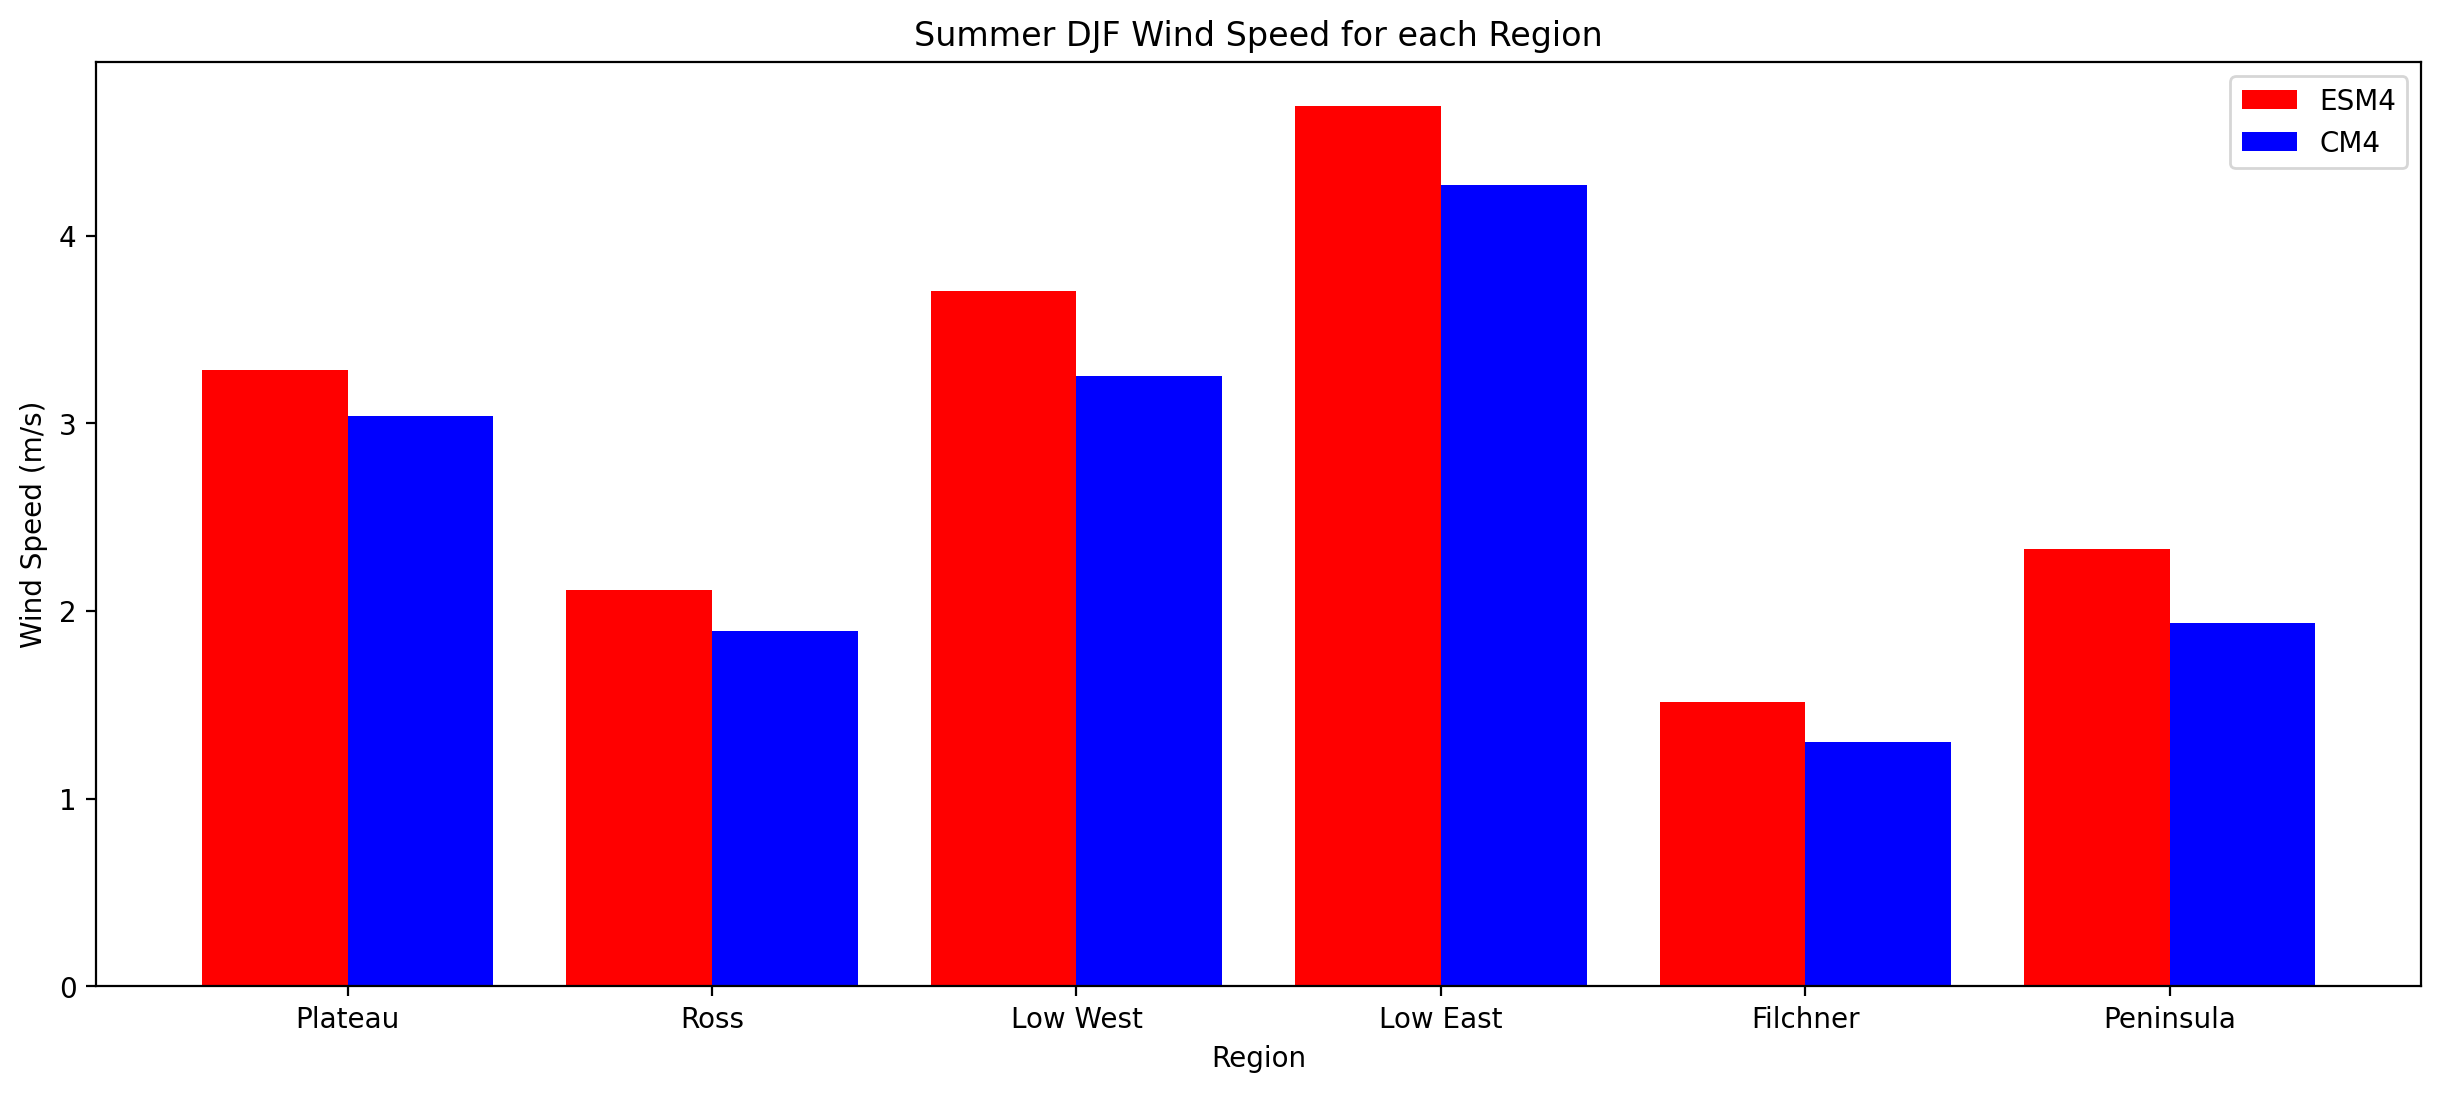

In [41]:
#bar plot showing differences in cm4 and esm4 data for regional summer windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = summer_cm4_values
ESM4 = summer_esm4_values
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, ESM4, 0.4, label = 'ESM4', color='r') 
plt.bar(X_axis + 0.2, CM4, 0.4, label = 'CM4', color= 'blue') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Summer DJF Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

# Winter 

In [42]:
ESM4_winter_szn_speed_rename=ESM4_winter_szn_speed.rename({'latitude': 'lat', 'longitude': 'lon'}) 
#time is already averaged out from speed slice
#here we are averaging the wind speed of each region into one value to compare on a bar plot
#this is annual windspeed averaged over 500 years
winter_plateau_temp_total_ESM4=(ESM4_winter_szn_speed_rename*(mask_ESM4.plateau_ESM4)).mean(dim='lat').mean(dim='lon')
winter_ross_temp_total_ESM4=(ESM4_winter_szn_speed_rename*(mask_ESM4.ross_ESM4)).mean(dim='lat').mean(dim='lon')
winter_lowwest_temp_total_ESM4=(ESM4_winter_szn_speed_rename*(mask_ESM4.lowwest_ESM4)).mean(dim='lat').mean(dim='lon')
winter_loweast_temp_total_ESM4=(ESM4_winter_szn_speed_rename*(mask_ESM4.loweast_ESM4)).mean(dim='lat').mean(dim='lon')
winter_filchner_temp_total_ESM4=(ESM4_winter_szn_speed_rename*(mask_ESM4.filchner_ESM4)).mean(dim='lat').mean(dim='lon')
winter_peninsula_temp_total_ESM4=(ESM4_winter_szn_speed_rename*(mask_ESM4.peninsula_ESM4)).mean(dim='lat').mean(dim='lon')

In [43]:
winter_plat_value_ESM4_total=print(winter_plateau_temp_total_ESM4.values)
winter_ross_value_ESM4_total= print(winter_ross_temp_total_ESM4.values)
winter_lowwest_value_ESM4_total=print(winter_lowwest_temp_total_ESM4.values)
winter_loweast_value_ESM4_total=print(winter_loweast_temp_total_ESM4.values)
winter_filch_value_ESM4_total=print(winter_filchner_temp_total_ESM4.values)
winter_pen_value_ESM4_total=print(winter_peninsula_temp_total_ESM4.values)

4.3697033
2.7392347
5.1295195
6.426908
2.1394496
2.8985934


In [44]:
winter_esm4_values=[4.3697033,
2.7392347,
5.1295195,
6.426908,
2.1394496,
2.8985934]

In [45]:
Winter_szn_speed
winter_plateau_temp_total_CM4=(Winter_szn_speed*(mask_CM4.plateau_CM4)).mean(dim='lat').mean(dim='lon')
winter_ross_temp_total_CM4=(Winter_szn_speed*(mask_CM4.ross_CM4)).mean(dim='lat').mean(dim='lon')
winter_lowwest_temp_total_CM4=(Winter_szn_speed*(mask_CM4.lowwest_CM4)).mean(dim='lat').mean(dim='lon')
winter_loweast_temp_total_CM4=(Winter_szn_speed*(mask_CM4.loweast_CM4)).mean(dim='lat').mean(dim='lon')
winter_filchner_temp_total_CM4=(Winter_szn_speed*(mask_CM4.filchner_CM4)).mean(dim='lat').mean(dim='lon')
winter_peninsula_temp_total_CM4=(Winter_szn_speed*(mask_CM4.peninsula_CM4)).mean(dim='lat').mean(dim='lon')

In [46]:
winter_plat_value_CM4_total=print(winter_plateau_temp_total_CM4.values)
winter_ross_value_CM4_total= print(winter_ross_temp_total_CM4.values)
winter_lowwest_value_CM4_total=print(winter_lowwest_temp_total_CM4.values)
winter_loweast_value_CM4_total=print(winter_loweast_temp_total_CM4.values)
winter_filch_value_CM4_total=print(winter_filchner_temp_total_CM4.values)
winter_pen_value_CM4_total=print(winter_peninsula_temp_total_CM4.values)

4.2856803
2.5993872
4.918551
6.2252374
1.9962525
2.6909878


In [47]:
winter_cm4_values=[4.2856803,
2.5993872,
4.918551,
6.2252374,
1.9962525,
2.6909878]


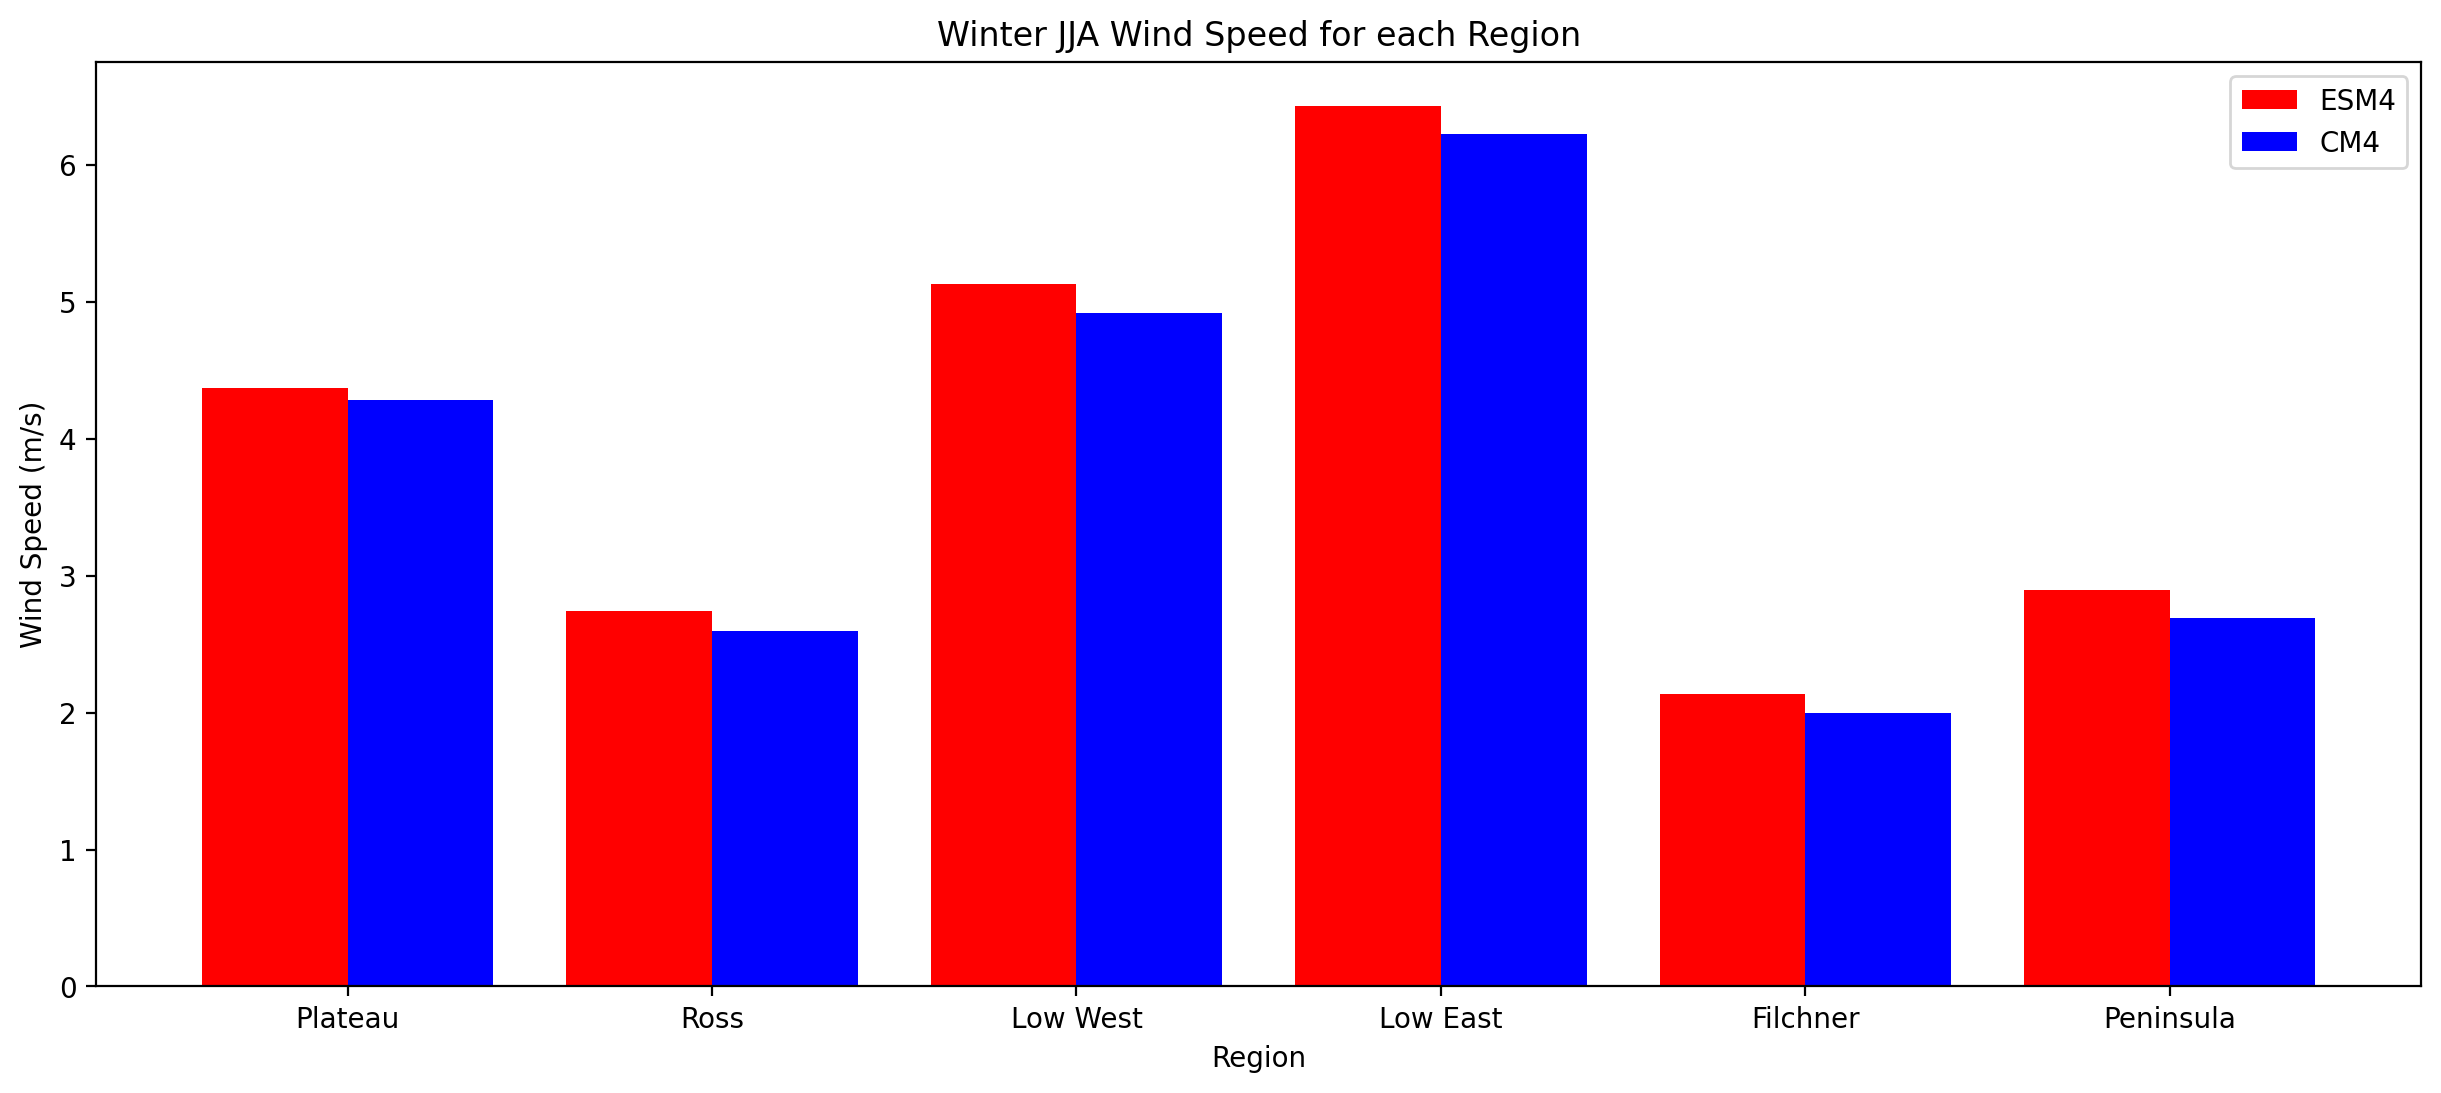

In [48]:
#bar plot showing differences in cm4 and esm4 data for regional summer windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = winter_cm4_values
ESM4 = winter_esm4_values
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, ESM4, 0.4, label = 'ESM4', color='r') 
plt.bar(X_axis + 0.2, CM4, 0.4, label = 'CM4', color= 'blue') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Winter JJA Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

# Fall

In [49]:
ESM4_fall_szn_speed_rename=ESM4_fall_szn_speed.rename({'latitude': 'lat', 'longitude': 'lon'}) 
#time is already averaged out from speed slice
#here we are averaging the wind speed of each region into one value to compare on a bar plot
#this is annual windspeed averaged over 500 years
fall_plateau_temp_total_ESM4=(ESM4_fall_szn_speed_rename*(mask_ESM4.plateau_ESM4)).mean(dim='lat').mean(dim='lon')
fall_ross_temp_total_ESM4=(ESM4_fall_szn_speed_rename*(mask_ESM4.ross_ESM4)).mean(dim='lat').mean(dim='lon')
fall_lowwest_temp_total_ESM4=(ESM4_fall_szn_speed_rename*(mask_ESM4.lowwest_ESM4)).mean(dim='lat').mean(dim='lon')
fall_loweast_temp_total_ESM4=(ESM4_fall_szn_speed_rename*(mask_ESM4.loweast_ESM4)).mean(dim='lat').mean(dim='lon')
fall_filchner_temp_total_ESM4=(ESM4_fall_szn_speed_rename*(mask_ESM4.filchner_ESM4)).mean(dim='lat').mean(dim='lon')
fall_peninsula_temp_total_ESM4=(ESM4_fall_szn_speed_rename*(mask_ESM4.peninsula_ESM4)).mean(dim='lat').mean(dim='lon')

In [50]:
fall_plat_value_ESM4_total=print(fall_plateau_temp_total_ESM4.values)
fall_ross_value_ESM4_total= print(fall_ross_temp_total_ESM4.values)
fall_lowwest_value_ESM4_total=print(fall_lowwest_temp_total_ESM4.values)
fall_loweast_value_ESM4_total=print(fall_loweast_temp_total_ESM4.values)
fall_filch_value_ESM4_total=print(fall_filchner_temp_total_ESM4.values)
fall_pen_value_ESM4_total=print(fall_peninsula_temp_total_ESM4.values)

4.5178056
2.909835
5.4226584
6.8297725
2.280201
3.0813706


In [51]:
fall_esm4_values=[4.5178056,
2.909835,
5.4226584,
6.8297725,
2.280201,
3.0813706]

In [52]:
Fall_szn_speed
fall_plateau_temp_total_CM4=(Fall_szn_speed*(mask_CM4.plateau_CM4)).mean(dim='lat').mean(dim='lon')
fall_ross_temp_total_CM4=(Fall_szn_speed*(mask_CM4.ross_CM4)).mean(dim='lat').mean(dim='lon')
fall_lowwest_temp_total_CM4=(Fall_szn_speed*(mask_CM4.lowwest_CM4)).mean(dim='lat').mean(dim='lon')
fall_loweast_temp_total_CM4=(Fall_szn_speed*(mask_CM4.loweast_CM4)).mean(dim='lat').mean(dim='lon')
fall_filchner_temp_total_CM4=(Fall_szn_speed*(mask_CM4.filchner_CM4)).mean(dim='lat').mean(dim='lon')
fall_peninsula_temp_total_CM4=(Fall_szn_speed*(mask_CM4.peninsula_CM4)).mean(dim='lat').mean(dim='lon')

In [53]:
fall_plat_value_CM4_total=print(fall_plateau_temp_total_CM4.values)
fall_ross_value_CM4_total= print(fall_ross_temp_total_CM4.values)
fall_lowwest_value_CM4_total=print(fall_lowwest_temp_total_CM4.values)
fall_loweast_value_CM4_total=print(fall_loweast_temp_total_CM4.values)
fall_filch_value_CM4_total=print(fall_filchner_temp_total_CM4.values)
fall_pen_value_CM4_total=print(fall_peninsula_temp_total_CM4.values)

4.493077
2.7982986
5.278062
6.6924567
2.172053
2.8668602


In [54]:
fall_cm4_values=[4.493077,
2.7982986,
5.278062,
6.6924567,
2.172053,
2.8668602]

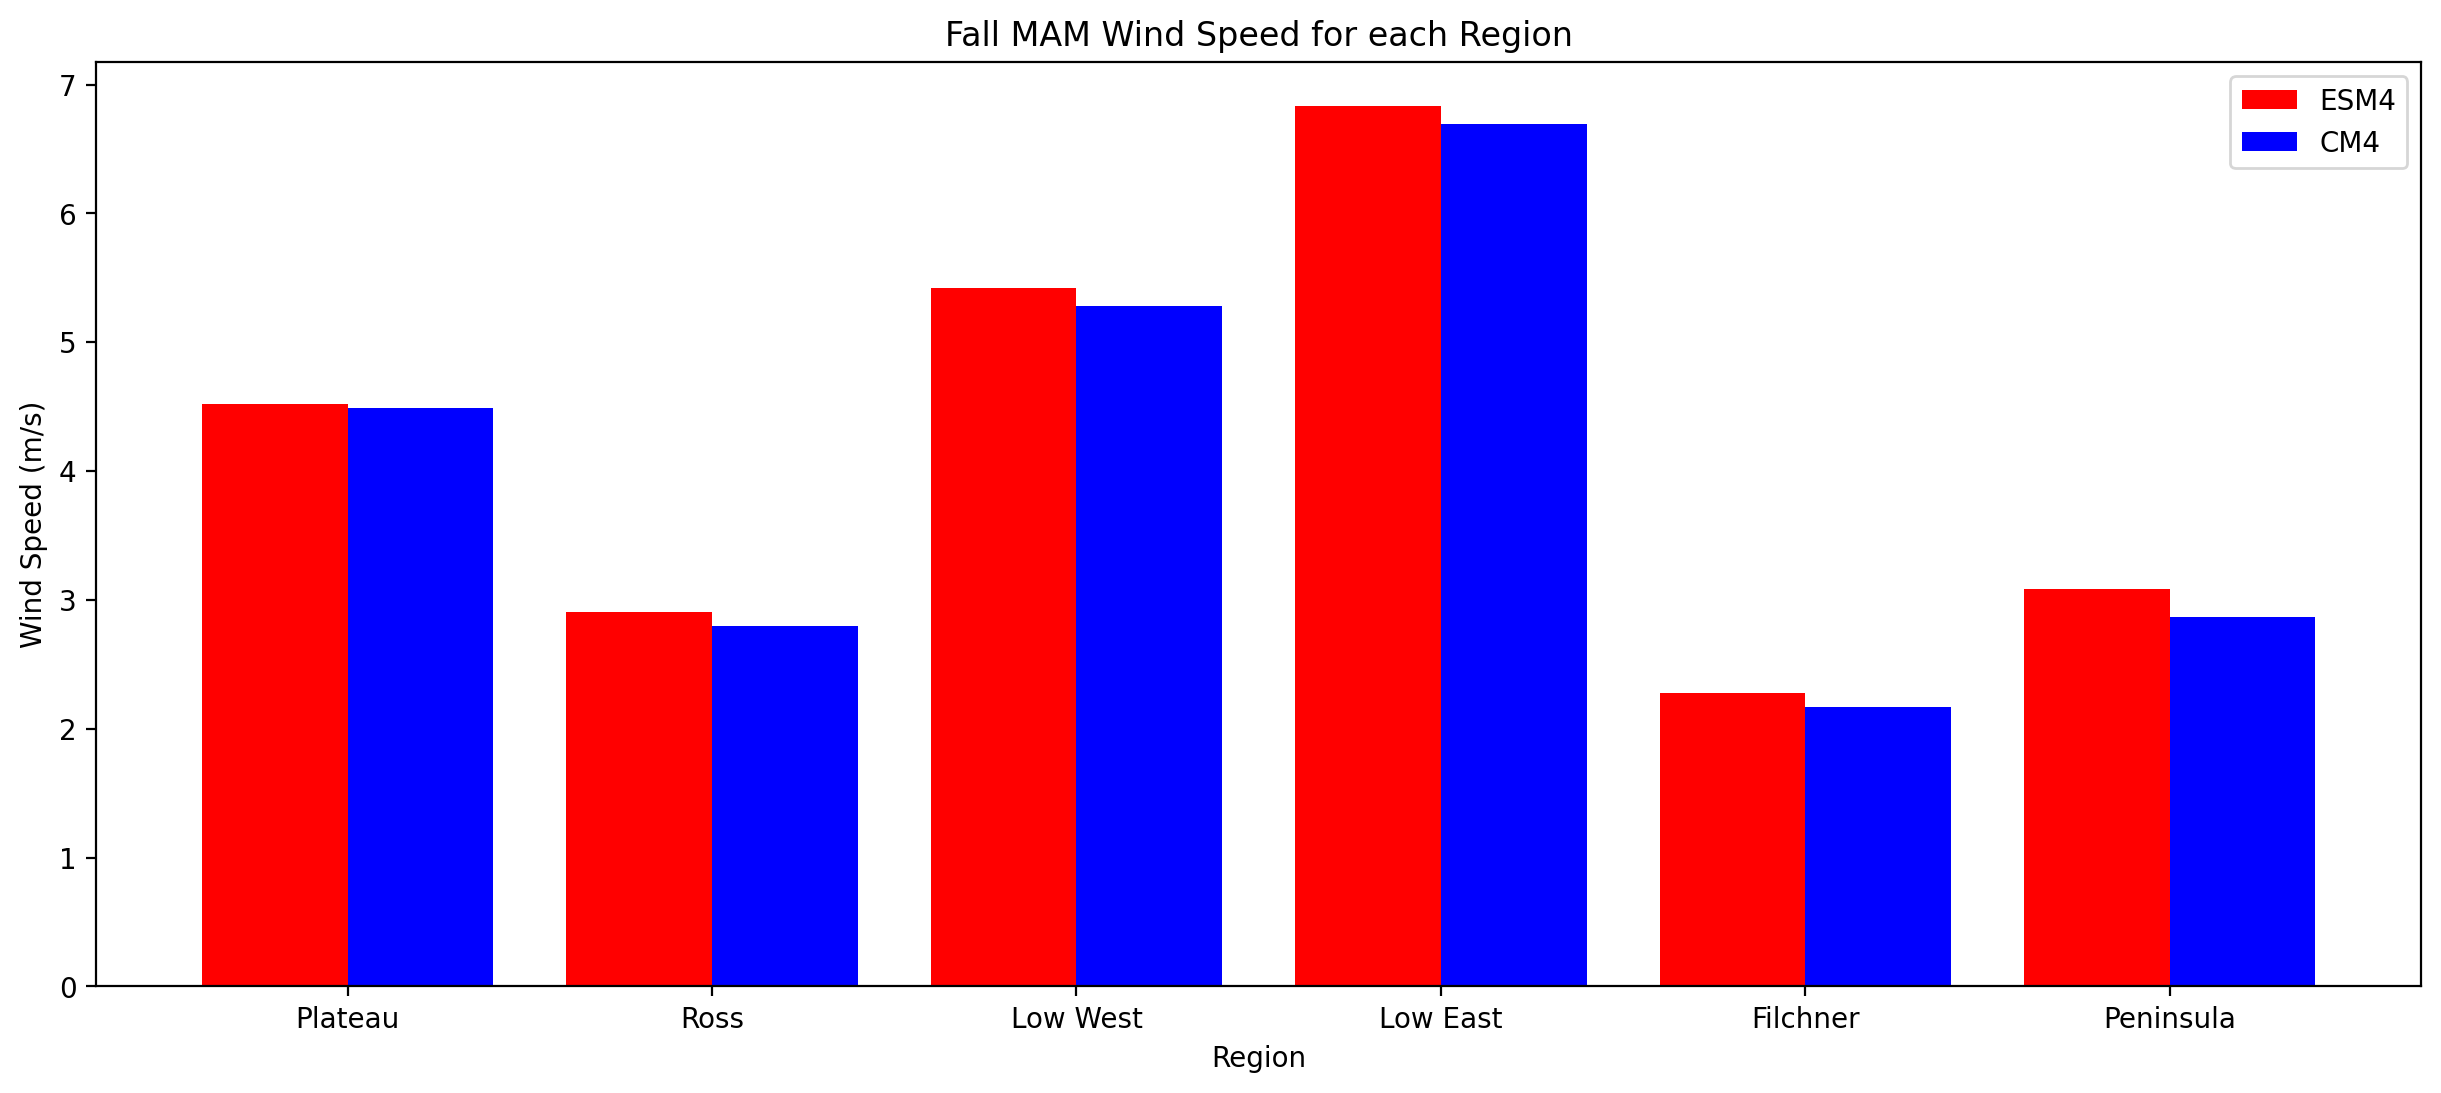

In [55]:
#bar plot showing differences in cm4 and esm4 data for regional summer windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = fall_cm4_values
ESM4 = fall_esm4_values
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, ESM4, 0.4, label = 'ESM4', color='r') 
plt.bar(X_axis + 0.2, CM4, 0.4, label = 'CM4', color= 'blue') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Fall MAM Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

# Spring

In [56]:
ESM4_spring_szn_speed_rename=ESM4_spring_szn_speed.rename({'latitude': 'lat', 'longitude': 'lon'}) 
#time is already averaged out from speed slice
#here we are averaging the wind speed of each region into one value to compare on a bar plot
#this is annual windspeed averaged over 500 years
spring_plateau_temp_total_ESM4=(ESM4_spring_szn_speed_rename*(mask_ESM4.plateau_ESM4)).mean(dim='lat').mean(dim='lon')
spring_ross_temp_total_ESM4=(ESM4_spring_szn_speed_rename*(mask_ESM4.ross_ESM4)).mean(dim='lat').mean(dim='lon')
spring_lowwest_temp_total_ESM4=(ESM4_spring_szn_speed_rename*(mask_ESM4.lowwest_ESM4)).mean(dim='lat').mean(dim='lon')
spring_loweast_temp_total_ESM4=(ESM4_spring_szn_speed_rename*(mask_ESM4.loweast_ESM4)).mean(dim='lat').mean(dim='lon')
spring_filchner_temp_total_ESM4=(ESM4_spring_szn_speed_rename*(mask_ESM4.filchner_ESM4)).mean(dim='lat').mean(dim='lon')
spring_peninsula_temp_total_ESM4=(ESM4_spring_szn_speed_rename*(mask_ESM4.peninsula_ESM4)).mean(dim='lat').mean(dim='lon')

In [57]:
spring_plat_value_ESM4_total=print(spring_plateau_temp_total_ESM4.values)
spring_ross_value_ESM4_total= print(spring_ross_temp_total_ESM4.values)
spring_lowwest_value_ESM4_total=print(spring_lowwest_temp_total_ESM4.values)
spring_loweast_value_ESM4_total=print(spring_loweast_temp_total_ESM4.values)
spring_filch_value_ESM4_total=print(spring_filchner_temp_total_ESM4.values)
spring_pen_value_ESM4_total=print(spring_peninsula_temp_total_ESM4.values)

4.552838
2.9509153
5.4774866
6.7675
2.324052
3.2664175


In [58]:
spring_esm4_values=[4.552838,
2.9509153,
5.4774866,
6.7675,
2.324052,
3.2664175]

In [59]:
Spring_szn_speed
spring_plateau_temp_total_CM4=(Spring_szn_speed*(mask_CM4.plateau_CM4)).mean(dim='lat').mean(dim='lon')
spring_ross_temp_total_CM4=(Spring_szn_speed*(mask_CM4.ross_CM4)).mean(dim='lat').mean(dim='lon')
spring_lowwest_temp_total_CM4=(Spring_szn_speed*(mask_CM4.lowwest_CM4)).mean(dim='lat').mean(dim='lon')
spring_loweast_temp_total_CM4=(Spring_szn_speed*(mask_CM4.loweast_CM4)).mean(dim='lat').mean(dim='lon')
spring_filchner_temp_total_CM4=(Spring_szn_speed*(mask_CM4.filchner_CM4)).mean(dim='lat').mean(dim='lon')
spring_peninsula_temp_total_CM4=(Spring_szn_speed*(mask_CM4.peninsula_CM4)).mean(dim='lat').mean(dim='lon')

In [60]:
spring_plat_value_CM4_total=print(spring_plateau_temp_total_CM4.values)
spring_ross_value_CM4_total= print(spring_ross_temp_total_CM4.values)
spring_lowwest_value_CM4_total=print(spring_lowwest_temp_total_CM4.values)
spring_loweast_value_CM4_total=print(spring_loweast_temp_total_CM4.values)
spring_filch_value_CM4_total=print(spring_filchner_temp_total_CM4.values)
spring_pen_value_CM4_total=print(spring_peninsula_temp_total_CM4.values)

4.515951
2.8464277
5.33254
6.6142874
2.2115076
3.0529358


In [61]:
spring_cm4_values=[4.515951,
2.8464277,
5.33254,
6.6142874,
2.2115076,
3.0529358]

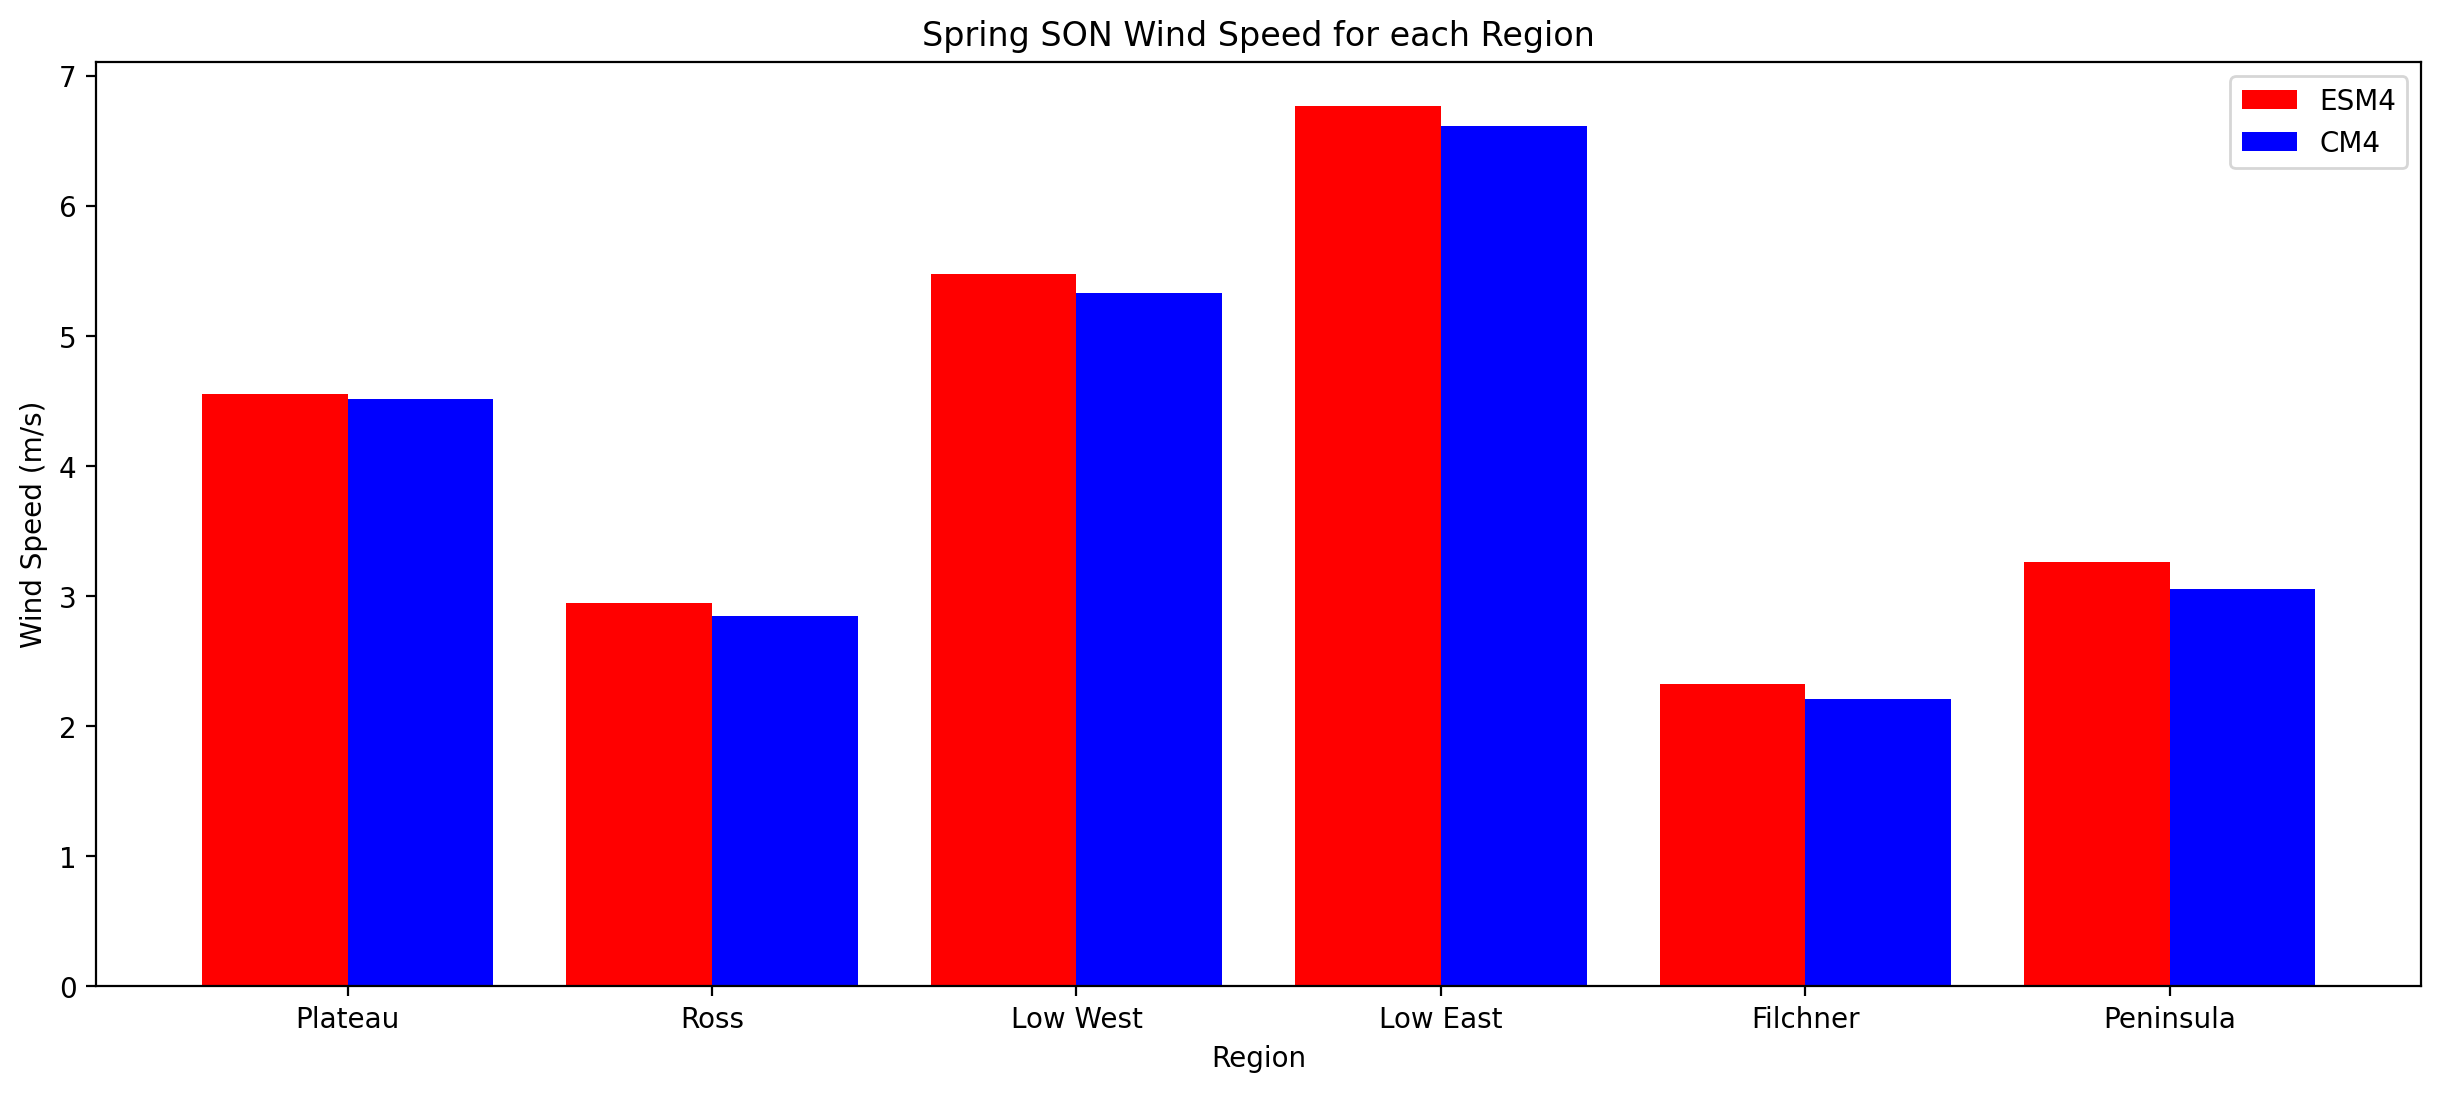

In [62]:
#bar plot showing differences in cm4 and esm4 data for regional summer windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = spring_cm4_values
ESM4 = spring_esm4_values
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, ESM4, 0.4, label = 'ESM4', color='r') 
plt.bar(X_axis + 0.2, CM4, 0.4, label = 'CM4', color= 'blue') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Spring SON Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

# ERA5 OBSERVATIONAL DATA
era5 is a reanalyses product

In [63]:
mask_ERA5= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ERA5_mask_antarctica.nc')

In [ ]:
#wind speed
era5_windspeed=xr.open_dataset('/home/tu.temple.edu/tuo15329/era5_wind/era5_10m_wind_speed_1940-2024_monthly_ensemble.nc')
ERA5_combine_windspeed =era5_windspeed.sel(expver=1).combine_first(era5_windspeed.sel(expver=5))
ERA5_combine_windspeed.load()
era5_windspeed_use=ERA5_combine_windspeed.si10.mean(dim='number')#.sel(time=slice('1995-01-01','2015-12-01'))

In [ ]:
era5_windspeed_use

In [ ]:
#era5_wind_speed=xr.open_dataset('/backup/tuq41374/observations/reanalysis/ERA5/era5_10m_wind_speed_1940_monthly_ensemble.nc')

In [ ]:
#creating seasonal slices of the data
#era5_seasonal=era5_wind_speed.groupby('time.season').mean(dim='time').mean(dim='number')
#era5_seasonal
#era5_summer=era5_seasonal.sel(season='DJF')
#era5_winter=era5_seasonal.sel(season='JJA')
#era5_spring=era5_seasonal.sel(season='SON')
#era5_fall=era5_seasonal.sel(season='MAM')

In [ ]:
#creating seasonal slices of the data with updated data
era5_seasonal=era5_windspeed_use.groupby('time.season').mean(dim='time')
era5_seasonal
era5_summer=era5_seasonal.sel(season='DJF')
era5_winter=era5_seasonal.sel(season='JJA')
era5_spring=era5_seasonal.sel(season='SON')
era5_fall=era5_seasonal.sel(season='MAM')

In [ ]:
plateau_wind_total_ERA5=(era5_windspeed_use*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
ross_wind_total_ERA5=(era5_windspeed_use*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
lowwest_wind_total_ERA5=(era5_windspeed_use*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
loweast_wind_total_ERA5=(era5_windspeed_use*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
filchner_wind_total_ERA5=(era5_windspeed_use*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
peninsula_wind_total_ERA5=(era5_windspeed_use*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')

In [ ]:
plat_value_ERA5_total=print(plateau_wind_total_ERA5.values)
ross_value_ERA5_total= print(ross_wind_total_ERA5.values)
west_value_ERA5_total=print(lowwest_wind_total_ERA5.values)
east_value_ERA5_total=print(loweast_wind_total_ERA5.values)
filch_value_ERA5_total=print(filchner_wind_total_ERA5.values)
pen_value_ERA5_total=print(peninsula_wind_total_ERA5.values)

In [ ]:
era5_wind_total_values=[7.405914,
6.29128,
7.0302005,
8.741001,
5.9537563,
7.109021]

In [ ]:
#bar plot showing differences in cm4 and esm4 data for regional annual windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = cm4_regional_annual_values
ESM4 = esm4_regional_annual_values
ERA=era5_wind_total_values
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4, 0.2, label = 'ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA, 0.2, label = 'ERA5', color= 'k') 

plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

In [ ]:
#summer era5 data
summer_plateau_wind_total_ERA5=(era5_summer*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude')
summer_ross_wind_total_ERA5=(era5_summer*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude')
summer_lowwest_wind_total_ERA5=(era5_summer*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude')
summer_loweast_wind_total_ERA5=(era5_summer*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude')
summer_filchner_wind_total_ERA5=(era5_summer*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude')
summer_peninsula_wind_total_ERA5=(era5_summer*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude')

In [ ]:
summer_plat_value_ERA5_total=print(summer_plateau_wind_total_ERA5.values)
summer_ross_value_ERA5_total= print(summer_ross_wind_total_ERA5.values)
summer_west_value_ERA5_total=print(summer_lowwest_wind_total_ERA5.values)
summer_east_value_ERA5_total=print(summer_loweast_wind_total_ERA5.values)
summer_filch_value_ERA5_total=print(summer_filchner_wind_total_ERA5.values)
summer_pen_value_ERA5_total=print(summer_peninsula_wind_total_ERA5.values)

In [ ]:
summer_era5_wind_total_values=[6.3057075,
5.480114,
5.8742366,
7.5475893,
5.2371707,
6.3252535]

In [ ]:
#bar plot showing differences in cm4 and esm4 data for regional annual windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = winter_cm4_values
ESM4 = winter_esm4_values
ERA=summer_era5_wind_total_values
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4, 0.2, label = 'ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA, 0.2, label = 'ERA5', color= 'k') 

plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Summer DJF Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

In [ ]:
#winter wind speed era5
winter_plateau_wind_total_ERA5=(era5_winter*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude')
winter_ross_wind_total_ERA5=(era5_winter*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude')
winter_lowwest_wind_total_ERA5=(era5_winter*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude')
winter_loweast_wind_total_ERA5=(era5_winter*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude')
winter_filchner_wind_total_ERA5=(era5_winter*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude')
winter_peninsula_wind_total_ERA5=(era5_winter*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude')

In [ ]:
winter_plat_value_ERA5_total=print(winter_plateau_wind_total_ERA5.values)
winter_ross_value_ERA5_total= print(winter_ross_wind_total_ERA5.values)
winter_west_value_ERA5_total=print(winter_lowwest_wind_total_ERA5.values)
winter_east_value_ERA5_total=print(winter_loweast_wind_total_ERA5.values)
winter_filch_value_ERA5_total=print(winter_filchner_wind_total_ERA5.values)
winter_pen_value_ERA5_total=print(winter_peninsula_wind_total_ERA5.values)

In [ ]:
winter_era5_wind_total_values=[8.110033,
6.7971044,
7.7098184,
9.564941,
6.3661103,
7.4663377]

In [ ]:
#bar plot showing differences in cm4 and esm4 data for regional annual windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = summer_cm4_values
ESM4 = summer_esm4_values
ERA=winter_era5_wind_total_values
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4, 0.2, label = 'ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA, 0.2, label = 'ERA5', color= 'k') 

plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Winter JJA Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

In [ ]:
#fall wind speed era5

In [ ]:
fall_plateau_wind_total_ERA5=(era5_fall*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude')
fall_ross_wind_total_ERA5=(era5_fall*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude')
fall_lowwest_wind_total_ERA5=(era5_fall*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude')
fall_loweast_wind_total_ERA5=(era5_fall*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude')
fall_filchner_wind_total_ERA5=(era5_fall*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude')
fall_peninsula_wind_total_ERA5=(era5_fall*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude')

In [ ]:
fall_plat_value_ERA5_total=print(fall_plateau_wind_total_ERA5.values)
fall_ross_value_ERA5_total= print(fall_ross_wind_total_ERA5.values)
fall_west_value_ERA5_total=print(fall_lowwest_wind_total_ERA5.values)
fall_east_value_ERA5_total=print(fall_loweast_wind_total_ERA5.values)
fall_filch_value_ERA5_total=print(fall_filchner_wind_total_ERA5.values)
fall_pen_value_ERA5_total=print(fall_peninsula_wind_total_ERA5.values)

In [ ]:
fall_era5_wind_total_values=[7.6568294,
6.495189,
7.3444376,
9.152266,
6.0636215,
7.2855315]


In [ ]:
#bar plot showing differences in cm4 and esm4 data for regional annual windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = fall_cm4_values
ESM4 = fall_esm4_values
ERA=winter_era5_wind_total_values
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4, 0.2, label = 'ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA, 0.2, label = 'ERA5', color= 'k') 

plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Fall MAM Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

In [ ]:
#spring wind speed era5

In [ ]:
spring_plateau_wind_total_ERA5=(era5_spring*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude')
spring_ross_wind_total_ERA5=(era5_spring*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude')
spring_lowwest_wind_total_ERA5=(era5_spring*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude')
spring_loweast_wind_total_ERA5=(era5_spring*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude')
spring_filchner_wind_total_ERA5=(era5_spring*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude')
spring_peninsula_wind_total_ERA5=(era5_spring*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude')

In [ ]:
spring_plat_value_ERA5_total=print(spring_plateau_wind_total_ERA5.values)
spring_ross_value_ERA5_total= print(spring_ross_wind_total_ERA5.values)
spring_west_value_ERA5_total=print(spring_lowwest_wind_total_ERA5.values)
spring_east_value_ERA5_total=print(spring_loweast_wind_total_ERA5.values)
spring_filch_value_ERA5_total=print(spring_filchner_wind_total_ERA5.values)
spring_pen_value_ERA5_total=print(spring_peninsula_wind_total_ERA5.values)

In [ ]:
spring_era5_wind_total_values=[7.5568666,
6.3967457,
7.1977715,
8.703817,
6.152523,
7.363112]

In [ ]:
#bar plot showing differences in cm4 and esm4 data for regional annual windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = spring_cm4_values
ESM4 = spring_esm4_values
ERA=spring_era5_wind_total_values
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4, 0.2, label = 'ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA, 0.2, label = 'ERA5', color= 'k') 

plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Spring SON Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

In [ ]:
#plateau_wind_total_ERA5=(era5_summer*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude')
#ross_wind_total_ERA5=(era5_summer*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude')
#lowwest_wind_total_ERA5=(era5_summer*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude')
#loweast_wind_total_ERA5=(era5_summer*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude')
#filchner_wind_total_ERA5=(era5_summer*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude')
#peninsula_wind_total_ERA5=(era5_summer*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude')

# Spatial Plots 

In [ ]:
def south_pole_map(cols=1, rows=1, fig_size=(12,8), max_extent=-50, facecolor='white'):
    ''' 
    User note: In order to call the function, begin cell with: fig, ax = south_pole_map(**args).
    
    Neglecting "fig, ax =" at the begeinning will not map your data to the existing axes.
    
    This function sets up a polar projection centered at the South Pole, which DataArrays can be plotted over.
    
    Optional arguments accepted for figure size, maximum (northward) extent and facecolor. Any number of columns and/or rows are also accepted for multiple subplots.
    
    If creating multiple subplots, ax=ax[*index*] must be passed in the plot call for each array.
    
    By default, these are set to (12,8), -50ºS and gray, respectively. Columns/Rows set to 1 by default – specifying axes in which to plot data is not necessary when using default column number.
    '''
    import matplotlib.path as mpath
    import numpy as np
    import cartopy.crs as ccrs
    
    fig,ax = plt.subplots(figsize=fig_size, ncols=cols, nrows=rows, subplot_kw={'projection': ccrs.SouthPolarStereo(), 'facecolor':facecolor}, layout='constrained')

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    if rows>1 and cols>1:
        for i in range(rows):
            for j in range(cols):
                ax[i,j].set_boundary(circle, transform=ax[i,j].transAxes)

                # lat/long map extents. shows south pole out to 50ºS
                ax[i,j].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif cols>1 and rows==1:
        for i in range(cols):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif rows>1 and cols==1:
        for i in range(rows):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    else:
        ax.set_boundary(circle, transform=ax.transAxes)

            # lat/long map extents. shows south pole out to 50ºS
        ax.set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    
    
    #must return fig, ax when creating multiple subplots in a function
    return fig, ax

In [ ]:
plateau_wind_total_CM4_spatial=(cm4_speedslice*(mask_CM4.plateau_CM4))
ross_wind_total_CM4_spatial=(cm4_speedslice*(mask_CM4.ross_CM4))
lowwest_wind_total_CM4_spatial=(cm4_speedslice*(mask_CM4.lowwest_CM4))
loweast_wind_total_CM4_spatial=(cm4_speedslice*(mask_CM4.loweast_CM4))
filchner_wind_total_CM4_spatial=(cm4_speedslice*(mask_CM4.filchner_CM4))
peninsula_wind_total_CM4_spatial=(cm4_speedslice*(mask_CM4.peninsula_CM4))

plateau_wind_total_ESM4_spatial=(esm4_speedslice_rename*(mask_ESM4.plateau_ESM4))
ross_wind_total_ESM4_spatial=(esm4_speedslice_rename*(mask_ESM4.ross_ESM4))
lowwest_wind_total_ESM4_spatial=(esm4_speedslice_rename*(mask_ESM4.lowwest_ESM4))
loweast_wind_total_ESM4_spatial=(esm4_speedslice_rename*(mask_ESM4.loweast_ESM4))
filchner_wind_total_ESM4_spatial=(esm4_speedslice_rename*(mask_ESM4.filchner_ESM4))
peninsula_wind_total_ESM4_spatial=(esm4_speedslice_rename*(mask_ESM4.peninsula_ESM4))

plateau_wind_total_ERA5_spatial=(era5_windspeed_use*(mask_ERA5.plateau_ERA5)).mean(dim='time')
ross_wind_total_ERA5_spatial=(era5_windspeed_use*(mask_ERA5.ross_ERA5)).mean(dim='time')
lowwest_wind_total_ERA5_spatial=(era5_windspeed_use*(mask_ERA5.lowwest_ERA5)).mean(dim='time')
loweast_wind_total_ERA5_spatial=(era5_windspeed_use*(mask_ERA5.loweast_ERA5)).mean(dim='time')
filchner_wind_total_ERA5_spatial=(era5_windspeed_use*(mask_ERA5.filchner_ERA5)).mean(dim='time')
peninsula_wind_total_ERA5_spatial=(era5_windspeed_use*(mask_ERA5.peninsula_ERA5)).mean(dim='time')

In [ ]:
fig, ax = south_pole_map(cols=3, rows=6,fig_size=(15,20))



#CM4 Plots
plateau_wind_total_CM4_spatial.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.thermal)
    
ross_wind_total_CM4_spatial.plot(ax=ax[1,0],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.thermal)
lowwest_wind_total_CM4_spatial.plot(ax=ax[2,0],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.thermal)
    
loweast_wind_total_CM4_spatial.plot(ax=ax[3,0],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.thermal)
peninsula_wind_total_CM4_spatial.plot(ax=ax[4,0],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
filchner_wind_total_CM4_spatial.plot(ax=ax[5,0],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
#ESM4 Plots

plateau_wind_total_ESM4_spatial.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.thermal)
    
ross_wind_total_ESM4_spatial.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.thermal)
lowwest_wind_total_ESM4_spatial.plot(ax=ax[2,1],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.thermal)
    
loweast_wind_total_ESM4_spatial.plot(ax=ax[3,1],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.thermal)
peninsula_wind_total_ESM4_spatial.plot(ax=ax[4,1],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
filchner_wind_total_ESM4_spatial.plot(ax=ax[5,1],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)

#ERA5 Plots
plateau_wind_total_ERA5_spatial.plot(ax=ax[0,2],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.thermal)
    
ross_wind_total_ERA5_spatial.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.thermal)
lowwest_wind_total_ERA5_spatial.plot(ax=ax[2,2],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.thermal)
    
loweast_wind_total_ERA5_spatial.plot(ax=ax[3,2],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.thermal)
peninsula_wind_total_ERA5_spatial.plot(ax=ax[4,2],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
filchner_wind_total_ERA5_spatial.plot(ax=ax[5,2],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
ax[0,0].coastlines()
ax[1,0].coastlines()
ax[2,0].coastlines()
ax[3,0].coastlines()
ax[4,0].coastlines()
ax[5,0].coastlines()

ax[0,1].coastlines()
ax[1,1].coastlines()
ax[2,1].coastlines()
ax[3,1].coastlines()
ax[4,1].coastlines()
ax[5,1].coastlines()

ax[0,2].coastlines()
ax[1,2].coastlines()
ax[2,2].coastlines()
ax[3,2].coastlines()
ax[4,2].coastlines()
ax[5,2].coastlines()

ax[0,0].set_title('CM4',size=15)
ax[0,1].set_title('ESM4',size=15)
ax[0,2].set_title('ERA5',size=15)

ax[1,2].set_title('')
ax[2,2].set_title('')
ax[3,2].set_title('')
ax[4,2].set_title('')
ax[5,2].set_title('')

rows = ['Peninsula', 'Ross', 'Low West', 'Low East', 'Peninsula', 'Filchner']

for ax, row in zip(ax[:,0], rows):
    ax.annotate(row, xy=(-30, 115), 
                xycoords='axes points', ha='center', va='center', color='k', rotation=90, fontsize=15)

fig.suptitle('Wind Speed (m/s)', fontsize=20)